In [2]:
import carla
import numpy as np
import time
import queue

In [3]:
client = carla.Client("localhost", 2000)

In [4]:

client.set_timeout(200.0)

In [5]:
world = client.get_world()

Extract Bounding Box

In [67]:
sidewalks = [sidewalk for index, sidewalk in enumerate(world.get_environment_objects(carla.CityObjectLabel.Sidewalks))]
sidewalk_names = [153, 154, 151, 199, 202, 201, 205, 203, 206, 157, 158, 155]
sidewalk_candidates = [sidewalk for sidewalk in sidewalks if any([str(name) in sidewalk.name and "Curb" not in sidewalk.name for name in sidewalk_names])]

In [66]:
len(sidewalk_candidates)

12

In [7]:
bbox_list = []
for index in range(len(sidewalk_candidates)):
    bbox = [[-bbox.x, -bbox.y] for bbox in sidewalk_candidates[index].bounding_box.get_world_vertices(sidewalk_candidates[index].transform)]
    bbox_list.append(bbox)

In [8]:
x_list = np.array(bbox_list)[:, :, 0]
y_list = np.array(bbox_list)[:, :, 1]

x_min, x_max = x_list.min(), x_list.max()
y_min, y_max = y_list.min(), y_list.max()

In [9]:
t = world.get_spectator().get_transform()
# coordinate_str = "(x,y) = ({},{})".format(t.location.x, t.location.y)
coordinate_str = "(x,y,z) = ({},{},{})".format(t.location.x, t.location.y,t.location.z)
print (coordinate_str)

(x,y,z) = (-2.5999999046325684,-2.0,3.8200066089630127)


Target Points

In [10]:
road_names = [121, 117, 169, 165, 120, 116, 168, 164, 167, 163, 162, 166, 207, 210, 119, 115, 118, 114, 80, 77, 113, 161, 156, 108]
roads = [road for index, road in enumerate(world.get_environment_objects(carla.CityObjectLabel.Roads)) if any([str(name) in road.name.split("_") for name in road_names])]

In [14]:
bbox_list = []
for road in roads:
    bbox = [[-pt.x, -pt.y] for pt in road.bounding_box.get_world_vertices(road.transform)]
    bbox_list.append(bbox)

In [16]:
bbox_list = []
for road in roads:
    bbox = [[-pt.x, -pt.y] for pt in road.bounding_box.get_world_vertices(road.transform)]
    bbox_list.append(bbox)

x_list = np.array(bbox_list)[:, :, 0]
y_list = np.array(bbox_list)[:, :, 1]

x_min, x_max = x_list.min(), x_list.max()
y_min, y_max = y_list.min(), y_list.max()

x_min, x_max, y_min, y_max

(-111.4085693359375, 17.19635009765625, -74.6965103149414, 74.51113891601562)

In [32]:
def linspace(start, stop, step):
    num = int((stop-start) / step + 1)
    return np.arange(0, num) * step + start

x_space = linspace(x_min, x_max, 1)
y_space = linspace(y_min, y_max, 1)

xv, yv = np.meshgrid(x_space, y_space)
world_grid = np.stack((xv, yv), axis=2)

In [33]:
world_grid = world_grid.reshape((-1, 2))

In [35]:
world_grid.shape

(19350, 2)

In [59]:
sidewalk_candidates

In [129]:
import carla
import numpy as np
import time
import queue
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.ops import cascaded_union


def extract_boundary(objects):
    bbox_list = []
    for ob in objects:
        bbox = MultiPoint([[-pt.x, -pt.y] for pt in ob.bounding_box.get_world_vertices(ob.transform)])
        bbox_list.append(bbox.convex_hull)
    boundary = MultiPolygon(Polygon(p.exterior) for p in bbox_list)
    return boundary


bbox_list = []
for ob in roads:
    bbox = MultiPoint([[-pt.x, -pt.y] for pt in ob.bounding_box.get_world_vertices(ob.transform)])
    bbox_list.append(bbox.convex_hull)

for ob in sidewalk_candidates:
    bbox = MultiPoint([[-pt.x, -pt.y] for pt in ob.bounding_box.get_world_vertices(ob.transform)])
    bbox_list.append(bbox.convex_hull)
boundary = cascaded_union(bbox_list)


road_boundary = extract_boundary(roads)
sidewalk_boundary = extract_boundary(sidewalk_candidates)

C:\Users\dajia\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.


In [130]:
target_grid = [any([Point(pt).within(boundary) for boundary in sidewalk_boundary]) for pt in world_grid]

C:\Users\dajia\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  """Entry point for launching an IPython kernel.


In [134]:
np.zeros((10, 3))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [136]:
from scipy import spatial

In [128]:
np.random.rand(10, 4).sum(axis=1)

array([2.03659741, 3.34650415, 2.32423538, 2.33654271, 2.0645872 ,
       1.47825952, 2.54679618, 2.51837449, 2.33604676, 2.80951565])

In [37]:
bbox_list = []
for ob in roads:
    bbox = Polygon([[-pt.x, -pt.y] for pt in ob.bounding_box.get_world_vertices(ob.transform)])
    bbox_list.append(bbox)

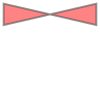

In [42]:
bbox_list[7]

Lidar Configuration

In [44]:
points_per_cloud = 50000
fps = 5

lidar_bp = world.get_blueprint_library().find("sensor.lidar.ray_cast")
lidar_bp.set_attribute('dropoff_general_rate', '0.35')
lidar_bp.set_attribute('dropoff_intensity_limit', '0.8')
lidar_bp.set_attribute('dropoff_zero_intensity', '0.4')
lidar_bp.set_attribute('points_per_second', str(points_per_cloud*fps))
lidar_bp.set_attribute('rotation_frequency', str(fps))
lidar_bp.set_attribute('channels', '16.0')
lidar_bp.set_attribute('lower_fov', '-15.0')
lidar_bp.set_attribute('upper_fov', '15.0')
lidar_bp.set_attribute('range', '100.0')
lidar_bp.set_attribute('noise_stddev', '0.02')
#blueprint = world.get_blueprint_library().find("sensor.camera.rgb")
sensor_location = carla.Location(x=-46, y=-7, z=5.5)
sensor_rotation = carla.Rotation(pitch=0, yaw=0, roll=0)
transform = carla.Transform(sensor_location, sensor_rotation)
sensor = world.spawn_actor(lidar_bp, transform)

In [45]:
q = queue.Queue()
# cc = carla.ColorConverter.Raw
sensor.listen(lambda data: q.put(data))
for i in range(3):
    sensor_data = q.get(True, 2.0)
print(sensor_data.raw_data)

In [46]:
points = np.copy(np.frombuffer(sensor_data.raw_data, dtype=np.dtype('f4')))
pcl = np.reshape(points, (int(points.shape[0] / 4), 4))

In [68]:
points = pcl[:, :3] + np.array([[sensor_location.x, sensor_location.y, sensor_location.z]])
points_2d = points[np.abs(points[:, 2]) <= 0.5, :2]

from shapely import geometry
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math

def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set of points.

    @param points: Iterable container of points.
    @param alpha: alpha value to influence the gooeyness of the border. Smaller
                  numbers don't fall inward as much as larger numbers. Too large,
                  and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense in computing an alpha
        # shape.
        return geometry.MultiPoint(list(points)).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    coords = np.array([point.coords[0] for point in points])

    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)

        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

concave_hull, edge_points = alpha_shape([geometry.Point([pt[0], pt[1]]) for pt in points_2d], alpha=1.87)

C:\Users\dajia\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:65: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.


In [17]:
points_2d

NameError: name 'points_2d' is not defined

<AxesSubplot:>

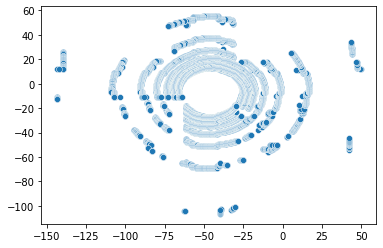

In [75]:
import seaborn as sns
sns.scatterplot(x = points_2d[:, 0], y = points_2d[:, 1])

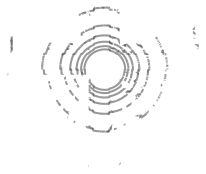

In [69]:
concave_hull

In [ ]:
len(points_2d)

In [33]:
sidewalk_candidates[0].transform

In [31]:
for item in list(dir(sidewalk_candidates[0])):
    if not item.endswith("__"):
        print(item)

bounding_box
id
name
transform
type


In [5]:
blueprint_library = world.get_blueprint_library()

In [6]:
carla_map = world.get_map()

In [20]:
[ob.id for ob in list(blueprint_library.filter(carla.CityObjectLabel.Sidewalks))]

ArgumentError: Python argument types in
    BlueprintLibrary.filter(BlueprintLibrary, CityObjectLabel)
did not match C++ signature:
    filter(carla::client::BlueprintLibrary {lvalue}, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > wildcard_pattern)

In [25]:
blueprint_library.find('vehicle.audi.a2')

In [36]:
len(carla_map.generate_waypoints(distance=100))

588

In [42]:
world.get_map().get_spawn_points()[0].location.x

-110.70001983642578

In [18]:
actor.bounding_box.

-9.832769393920898

In [29]:
world.get_level_bbs(carla.CityObjectLabel.Sidewalks)[0].get_world_vertices()


ArgumentError: Python argument types in
    BoundingBox.get_world_vertices(BoundingBox)
did not match C++ signature:
    get_world_vertices(class carla::geom::BoundingBox, class carla::geom::Transform bbox_transform)

In [12]:
carla.CityObjectLabel.Buildings

carla.libcarla.CityObjectLabel.Buildings

In [7]:
actor = world.get_actors()[0]
actor.get_world_vertices(actor.get_transform())


AttributeError: 'TrafficLight' object has no attribute 'get_world_vertices'

In [15]:
t = world.get_spectator().get_transform()
coordinate_str = "(x,y,z) = ({},{},{})".format(t.location.x, t.location.y,t.location.z)

In [16]:
coordinate_str

'(x,y,z) = (-53.82551574707031,8.209002494812012,2.778019666671753)'

In [12]:
location = t.location
w = carla_map.get_waypoint(location)

In [19]:
w.previous_until_lane_start(10)

In [25]:
waypoints = carla_map.generate_waypoints(1000)
for w in waypoints:
    world.debug.draw_string(w.transform.location, 'O', draw_shadow=False,
                                       color=carla.Color(r=255, g=0, b=0), life_time=120.0,
                                       persistent_lines=True)

In [28]:
world.debug.draw_string(w.transform.location, 'O', draw_shadow=False,
                                       color=carla.Color(r=255, g=0, b=0), life_time=120.0,
                                       persistent_lines=True)

In [27]:
w.transform.location.x

-109.69247436523438

In [55]:
for actor_snapshot in world_snapshot:
    print(world.get_actor(actor_snapshot.id).type_id)

traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.traffic_light
traffic.tr

In [56]:
sumo_network = carla.SumoNetwork

AttributeError: module 'carla' has no attribute 'SumoNetwork'

In [82]:
import scipy
import numpy


A = np.random.rand(10000, 2)
B = np.random.rand(1000000, 2)
dists = scipy.spatial.distance.cdist(A, B)

In [83]:
dists.shape

(10000, 1000000)